# RQ2 Analysis
This notebook contains the analysis for RQ2. The goal of this analysis is to understand the evolution of the serialization format used in the dataset over the years.

## Select the dataset to analyze

In [122]:
group_under_analysis = 'recent'  # change this to 'legacy' or 'recent' to analyze the corresponding dataset

## Load the data

In [123]:
from scripts.notebooks.nb_utils import read_repositories_evolution

# model files per repository and the elapsed days between the commit and safetensors' release date
df = read_repositories_evolution(group_under_analysis)
df['year'] = df['date'].dt.year
df['year'] = df['year'].astype(int)  # set year as an integer
# find the last commit hash per repository per year
df_last_hash = df.sort_values('date').drop_duplicates(['repo_url', 'year'], keep='last')
df_last_hash = df_last_hash[['repo_url', 'year', 'commit_hash', 'date']]

# filter df such that it  only keeps the rows in df if the commit hash is the last commit hash in the repository URL
df = df.merge(df_last_hash, on=['repo_url', 'year', 'date', 'commit_hash'], how='inner')
"Min date", df['date'].min(), "Max date", df['date'].max()
year_range = list(range(df['year'].min(), df['year'].max() + 1))


100%|██████████| 527512/527512 [01:01<00:00, 8631.68commit/s] 


## Visualization of serialization format distribution over the years

In [124]:
title_suffix = f'({group_under_analysis.capitalize()} Repositories)' if group_under_analysis != 'both' else '(All Repositories)'
fig_dimensions = (7, 4) if group_under_analysis != 'recent' else (6, 4)

### Stacked Bar Chart

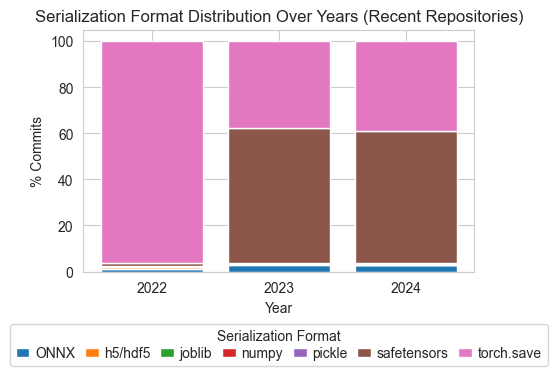

In [125]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt
import numpy as np

# Sample dataqa
df = df[df['serialization_format'] != 'undetermined']
# Compute a slice of the DataFrame with the relevant columns
df_by_date = df[['year', 'serialization_format']]

# Group by year and serialization format, then count occurrences
grouped = df_by_date.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot
fig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis

# Cumulative values for stacked bars
cumulative_values = np.zeros(len(grouped_percentage))

for serialization_format in grouped_percentage.columns:
    ax.bar(grouped_percentage.index, grouped_percentage[serialization_format],
           bottom=cumulative_values, label=serialization_format)
    cumulative_values += grouped_percentage[serialization_format]

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_xticks(year_range)  # Tick every year
ax.set_title(f'Serialization Format Distribution Over Years {title_suffix}')
# Move the legend outside  the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7,
          labelspacing=0.2,  # Reduce vertical space between labels
          handlelength=1.0,  # Shorter line handles
          handletextpad=0.4,  # Less space between handle and text
          borderaxespad=0.3,  # Padding between legend and axes
          borderpad=0.4,  # Padding inside the legend box
          columnspacing=0.7  # Horizontal space between columns (if used)
          )
# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.85, 1])

# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsStacked_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')
plt.show()


### Line Chart

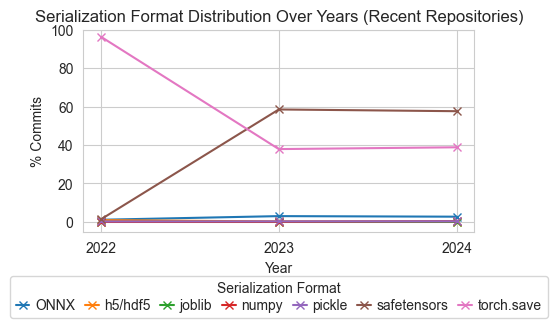

In [126]:
from nb_utils import RESULTS_DIR
import matplotlib.pyplot as plt

# Group by year and serialization format, then count occurrences
grouped = df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Normalize the values to 100%
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the line chart
fig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis
# make y-axis range from 0 to 100
ax.set_ylim(-5, 100)

# Plot lines for each serialization format
for serialization_format in grouped_percentage.columns:
    ax.plot(grouped_percentage.index, grouped_percentage[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('% Commits')
ax.set_xlabel('Year')
ax.set_xticks(year_range)  # Tick every year
ax.set_title(f'Serialization Format Distribution Over Years {title_suffix}')
# Move the legend outside  the plot
ax.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7,
          # fontsize='small',
          labelspacing=0.2,  # Reduce vertical space between labels
          handlelength=1.0,  # Shorter line handles
          handletextpad=0.4,  # Less space between handle and text
          borderaxespad=0.3,  # Padding between legend and axes
          borderpad=0.4,  # Padding inside the legend box
          columnspacing=0.7  # Horizontal space between columns (if used)
          )

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.1, 0.85, 1])  # Adjust the rectangle to fit the legend

# save as pdf
plt.savefig(RESULTS_DIR / f'RQ2FormatsDistribution_{group_under_analysis}.pdf', format='pdf', bbox_inches='tight')

plt.show()

### Line Chart with Counts

import matplotlib.pyplot as plt


# Filter out rows with 'undetermined' serialization format
filtered_df = df[df['serialization_format'] != 'undetermined']
# Group by year and serialization format, then count occurrences
grouped_counts = filtered_df.groupby(['year', 'serialization_format']).size().unstack(fill_value=0)

# Set the size of the figure (width, height)
fig, ax = plt.subplots(figsize=fig_dimensions)  # Set the figure size based on the group under analysis

# Plot the line chart with counts
for serialization_format in grouped_counts.columns:
    ax.plot(grouped_counts.index, grouped_counts[serialization_format], marker='x', label=serialization_format)

# Add labels and title
ax.set_ylabel('# Model Files')
ax.set_xlabel('Year')
ax.set_title(f'Serialization Format Cumulative Totals Over Years {title_suffix}')

# Move the legend outside of the plot
ax.legend(title='Serialization Format',  bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7)

# Adjust the plot layout to make room for the legend
plt.tight_layout(rect=[0, 0.3, 0.85, 1])

plt.show()


### Visualization monthly

import pandas as pd
from scripts.notebooks.nb_utils import read_repositories_evolution
# Load the CSV file
df = read_repositories_evolution(group_under_analysis)


# Display the first few rows to understand the structure of the data
df.head()
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the month-year period for grouping
df['month'] = df['date'].dt.to_period('M')

# Sort by date to identify the last commit within each group
df = df.sort_values(by=['repo_url', 'month', 'date'])

# Select the last commit for each repository within each month
last_commit_df = df.groupby(['repo_url', 'month']).last().reset_index()

# Count the occurrences of each serialization format per month
serialization_distribution = last_commit_df.groupby(['month', 'serialization_format']).size().unstack(fill_value=0)

# Plotting the distribution using a line chart
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
serialization_distribution.plot(kind='line', marker='x', figsize=(14, 7))
plt.title('Monthly Distribution of Serialization Formats (Last Commit per Repo) ' + title_suffix)
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Serialization Format')
plt.tight_layout()
plt.show()


# Calculate the percentage distribution instead of raw counts
serialization_percentage_distribution = serialization_distribution.div(serialization_distribution.sum(axis=1), axis=0) * 100
# Exclude 'undetermined' serialization format
serialization_percentage_distribution = serialization_percentage_distribution.drop(columns=['undetermined'], errors='ignore')


# # Plotting the percentage distribution using a line chart
# plt.figure(figsize=(12, 6))
# serialization_percentage_distribution.plot(kind='line', marker='x', figsize=(14, 7))
# plt.title('Monthly Percentage Distribution of Serialization Formats (Last Commit per Repo)')
# plt.xlabel('Month')
# plt.ylabel('Percentage')
# plt.xticks(rotation=45)
# plt.grid(True)
# plt.legend(title='Serialization Format')
# plt.tight_layout()
# plt.show()

# Plotting the modified chart
plt.figure(figsize=(12, 6))
ax = serialization_percentage_distribution.plot(kind='line', marker='x', figsize=(14, 7))

plt.title('Monthly Percentage Distribution of Serialization Formats (Last Commit per Repo)')
plt.xlabel('Month')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True)

# Move the legend outside the plot
plt.legend(title='Serialization Format', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)
plt.tight_layout()
plt.show()
